Tree Density Analysis

In [51]:
# Packages
import geopandas as gpd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import fiona
import os

In [68]:
# Reading in shapefiles
trees_path = Path(r"C:\\Users\\Jena-\\syracusetrees\\shapefiles\\Syracuse_Tree_Data\\Syracuse_Tree_Data.shp")
tracts_path = Path(r"C:\\Users\\Jena-\\syracusetrees\\shapefiles\\Census_Tracts_in_Syracuse_NY\\Census_Tracts_in_Syracuse_NY_-_2020.shp")

trees = gpd.read_file(trees_path)
tracts = gpd.read_file(tracts_path)
tracts = tracts.to_crs(epsg=26918)
trees = trees.to_crs(epsg=26918)

In [94]:
# Spatial Join
trees_per_tract = tree_tract.groupby('TRACTCE20').size().reset_index(name='tree_count')

In [96]:
# Calculating area and density
trees_per_tract = tree_tract.groupby('TRACTCE20').size().reset_index(name='tree_count')
tracts_with_counts = tracts.merge(trees_per_tract, on='TRACTCE20', how='left')
tracts_with_counts['tree_count'] = tracts_with_counts['tree_count'].fillna(0)
tracts_with_counts['area_km2'] = tracts_with_counts.geometry.area / 10**6
tracts_with_counts['tree_density'] = tracts_with_counts['tree_count'] / tracts_with_counts['area_km2']


(np.float64(401407.6255835014),
 np.float64(413018.2834264848),
 np.float64(4759148.403513772),
 np.float64(4771598.94972032))

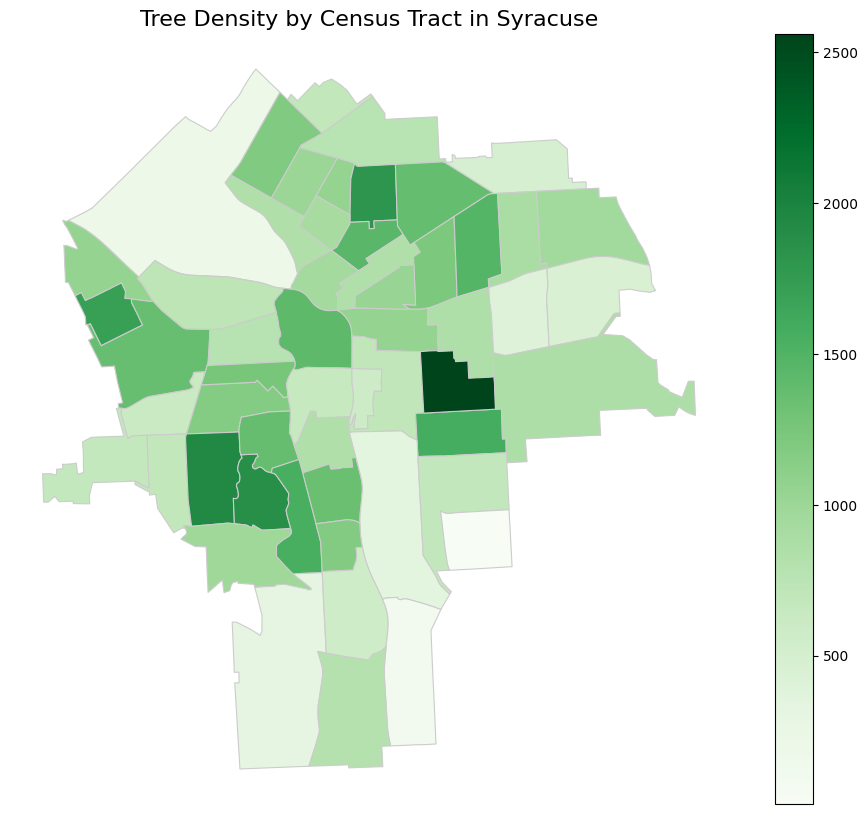

In [ ]:
# Plot density
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
tracts_with_counts.plot(
    column='tree_density',
    cmap='Greens',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,           
    ax=ax
)
ax.set_title('Tree Density by Census Tract in Syracuse, NY', fontsize=16)
ax.axis('off')
